# Tutorial

```self.clean(self, inputs, data=None, **kwargs)```

This is a tutorial for the 'clean' method, a necessary step for ensuring FoKL may process almost any dataset. In the
following script, it will be shown how 'clean' may be used to automatically format and normalize a raw dataset, only format, or normalize to a wider range of values which is most useful for applications in the 'update' method.

In [10]:
# # -----------------------------------------------------------------------
# # Local version of 'from FoKL import FoKLRoutines':
# import os
# import sys
# dir = os.path.abspath('')  # directory of script
# sys.path.append(dir)
# sys.path.append(os.path.join(dir, '..', '..'))  # package directory
# from src.FoKL import FoKLRoutines
# # -----------------------------------------------------------------------
from FoKL import FoKLRoutines
# -----------------------------------------------------------------------
import numpy as np


# Example dataset:
inputs = [np.linspace(0, 10, 100), 10 * np.random.rand(100)]
data = inputs[0] ** 2 + inputs[1]

# Initialize FoKL class object:
model = FoKLRoutines.FoKL(UserWarnings=False)

## Standard Use

(ignore ```_setattr=True```; this may be left out when using ```clean```)

If the raw dataset is thought to be complete, without new data expected, but most importantly without new input variable mininma or maxima expected, 'clean' only needs to be called once.

To train on the entire dataset,

In [11]:
model.clean(inputs, data, _setattr=True)

print(model.minmax)
print([[np.min(model.inputs[:, 0]), np.max(model.inputs[:, 0])], [np.min(model.inputs[:, 1]), np.max(model.inputs[:, 1])]])

[[0.0, 10.0], [0.04383571314254042, 9.995348412588012]]
[[0.0, 1.0], [0.0, 1.0]]


To train on a percentage (i.e., (0, 1) fraction) of the dataset selected randomly,

In [12]:
_ = model.clean(inputs, data, train=0.8, _setattr=True)

## Anticipating New Data

If it is expected that future evaluations of the model will be done at inputs beyond what the training set contains, the normalization [min, max] bounds may be expanded in a couple ways.

Most simply, [min, max] may be specified.

In [13]:
model.clean(inputs, data, minmax=[[-1, 12], [0, 10]], _setattr=True)  # expand bounds of first input variable

print(model.minmax)
print([[np.min(model.inputs[:, 0]), np.max(model.inputs[:, 0])], [np.min(model.inputs[:, 1]), np.max(model.inputs[:, 1])]])

[[-1, 12], [0, 10]]
[[0.07692307692307693, 0.8461538461538461], [0.004383571314254042, 0.9995348412588012]]


A pillow buffer may also be specified. The pillow may either be as a percent of the max-min span (default),

In [14]:
model.clean(inputs, data, pillow=[[0.1, 0.2], [0, 0]], _setattr=True)  # 10% of span added below min; 20% of span added above max

print(model.minmax)
print([[np.min(model.inputs[:, 0]), np.max(model.inputs[:, 0])], [np.min(model.inputs[:, 1]), np.max(model.inputs[:, 1])]])

[[-2.3, 14.6], [0, 10]]
[[0.13609467455621302, 0.727810650887574], [0.004383571314254042, 0.9995348412588012]]


Or, the pillow may be the values to which [min, max] will map when placed on a 0-1 scale by setting ```pillow_type='absolute'```, with the upper value being the distance less than 1,

In [15]:
model.clean(inputs, data, pillow=[[0.1, 0.2], [0, 0]], pillow_type='absolute', _setattr=True)  # inputs map to [0.1, 0.8] 

print(model.minmax)
print([[np.min(model.inputs[:, 0]), np.max(model.inputs[:, 0])], [np.min(model.inputs[:, 1]), np.max(model.inputs[:, 1])]])

[[-4.7142857142857135, 19.428571428571423], [0, 10]]
[[0.1952662721893491, 0.6094674556213019], [0.004383571314254042, 0.9995348412588012]]


## New Data

Often it is the case that new data must be formatted and normalized according to the previous [min, max] bounds. To achieve this,

In [16]:
model.clean([[0.4, 8.7, 4.3], [4.2, 6, 8.5]], _setattr=True)

print(model.inputs)

[[0.21183432 0.42      ]
 [0.5556213  0.6       ]
 [0.37337278 0.85      ]]


Or, if normalization has already been applied to the new data somehow and all that is desired is the automatic formatting,

In [17]:
model.clean([[0.4, 8.7, 4.3], [4.2, 6, 8.5]], normalize=False, _setattr=True)

print(model.inputs)

[[0.4 4.2]
 [8.7 6. ]
 [4.3 8.5]]


Additionally, if simply wishing to format any dataset (e.g., Pandas) into an $[n \times m]$ ndarray of $n$ datapoints and $m$ input variables, where $n \gt m$,

In [18]:
import pandas as pd


pd_data = np.array([[0.4, 8.7, 4.3], [4.2, 6, 8.5]])    # example data
pd_rows = ['x0', 'x1']                                  # example input variables
pd_cols = ['A', 'B', 'C']                               # example instances
pd_dataset = pd.DataFrame(pd_data, pd_rows, pd_cols)    # example Pandas dataset

print("Original dataset:")
print(pd_dataset)

# ------------------------

formatted_dataset = model.clean(pd_dataset, normalize=False)

print("\nDataset automatically formatted:")
print(formatted_dataset)

# ------------------------

del model.minmax  # delete 'model.minmax' since previously defined and 'model.clean(..., minmax=None)' in next line, because will normalize to these bounds instead of this dataset's [min, max]
normalized_dataset = model.clean(formatted_dataset)  # use 'copy.copy(formatted_dataset)' if not wanting to overwrite 'formatted_dataset'

print("\nFormatted dataset automatically normalized:")
print(normalized_dataset)

Original dataset:
      A    B    C
x0  0.4  8.7  4.3
x1  4.2  6.0  8.5

Dataset automatically formatted:
[[0.4 4.2]
 [8.7 6. ]
 [4.3 8.5]]

Formatted dataset automatically normalized:
[[0.         0.        ]
 [1.         0.41860465]
 [0.46987952 1.        ]]


However, if $m \gt n$ (i.e., more input variables than instances), then be careful that ndarray is aligned accordingly. In this case, use ```AutoTranspose=False``` to preserve shape of original dataset:

In [19]:
pd_rows = ['A', 'B']                                    # example instances
pd_cols = ['x0', 'x1', 'x2']                            # example input variables
pd_dataset = pd.DataFrame(pd_data, pd_rows, pd_cols)    # example Pandas dataset

print("Original dataset:")
print(pd_dataset)

# ------------------------

print("\nDataset automatically formatted (with 'AutoTranspose=False'):")
print(model.clean(pd_dataset, normalize=False, AutoTranspose=False))

Original dataset:
    x0   x1   x2
A  0.4  8.7  4.3
B  4.2  6.0  8.5

Dataset automatically formatted (with 'AutoTranspose=False'):
[[0.4 8.7 4.3]
 [4.2 6.  8.5]]


## Use in fit and evaluate

To use ```clean``` in ```fit``` and ```evaluate```, simply pass keywords into the function arguments.

[1, 517.0464138404218]
[2, 517.0464138404218]
[2, -294.6364409687906]
[3, -294.6364409687906]
[3, -298.8398238770909]
[4, -298.8398238770909]
[4, -298.8398238770909]
[4, -649.3022820024937]
[5, -655.5376100317794]
[5, -665.4010311834971]
[5, -706.6612485231734]
[6, -706.6612485231734]
[6, -715.4259120137979]
[6, -715.4259120137979]
[6, -928.9337228975271]
[7, -948.8205776433674]
[7, -948.8205776433674]
[7, -948.8205776433674]
[7, -1003.7555209494859]
[8, -1005.0202144606648]
[8, -1005.0202144606648]
[8, -1005.0202144606648]
[8, -1005.0202144606648]


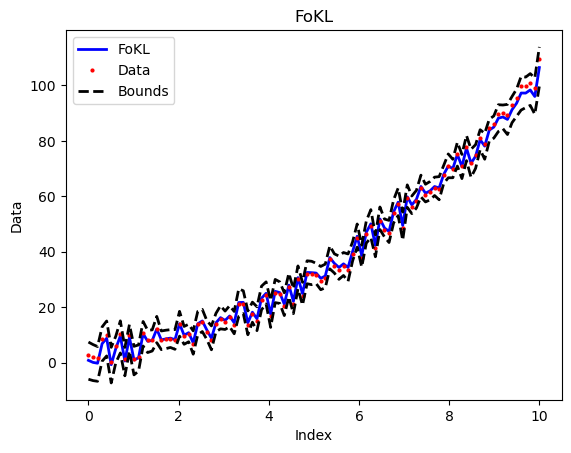

[ 3.07894273 81.04990837 27.5993045 ]


In [20]:
del model.minmax  # delete 'model.minmax' since previously defined and 'model.clean(..., minmax=None)' in next line, because will normalize to these bounds instead of this dataset's [min, max]

model.fit(inputs, data, clean=True, pillow=[[0.1, 0.2], [0, 0]], pillow_type='absolute')
model.coverage3(plot=True, xaxis=0)  # validation plot

print(model.evaluate([[0.4, 8.7, 4.3], [4.2, 6, 8.5]], clean=True))

Note in typical use, ```del model.minmax``` should not be needed. It is expected that the normalization 'minmax' bounds will only need to be defined once when first calling ```clean```. The only reason ```del model.minmax``` was used in this tutorial was to showcase the flexible ways ```clean``` behaves when first being called (i.e., before ```model.minmax``` is defined). For thoroughness, if ```minmax``` is defined in the ```clean``` function argument, ```model.minmax``` gets overrided; though, there is likely not a typical use case for this.